# Modern Portfolio Theory (Markowitz-model)

In [223]:
import requests
import pandas as pd
import seaborn as sns
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.optimize as opt

In [39]:
sns.set(style='darkgrid')

## Where I am going to get my data? AlphaVantage

In [101]:
def get_data(stock):
    
    key = '*'
    
    url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={stock}&apikey={key}&outputsize=full"
    
    r = requests.get(url)
    r.raise_for_status()
    
    return pd.DataFrame.from_dict(r.json()['Time Series (Daily)'], orient='index')

In [102]:
data = get_data('IBM')

In [103]:
data.head()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
2020-08-05,126.7300,126.7500,124.6100,125.4500,125.4500,3675400,0.0000,1.0000
2020-08-04,123.8200,125.8600,123.8200,125.8400,125.8400,3431366,0.0000,1.0000
2020-08-03,123.5000,124.4100,122.1500,124.3100,124.3100,3526574,0.0000,1.0000
2020-07-31,122.7100,122.9900,121.0900,122.9400,122.9400,5277652,0.0000,1.0000
2020-07-30,123.7100,123.9046,121.6400,122.9000,122.9000,3988062,0.0000,1.0000


Lets Check whether our daily returns has a normal distribution ? This is important as this is the primary assumption of modern portfolio theory

In [37]:
returns = data['5. adjusted close'].astype('float').pct_change()

<AxesSubplot:>

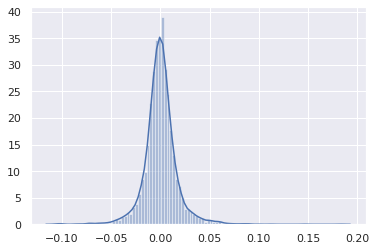

In [40]:
sns.distplot(returns.values, bins=100)

## Let's get started

### Get Data

In [41]:
stocks = ['AAPL', 'WMT', 'TSLA', 'GE', 'AMZN', 'DB']

In [50]:
start_date = '2010-01-01'
end_date = '2017-01-01'

Grab data for the stocks defined above

In [104]:
final = []
for i in stocks:
    print(f'Getting data for {i}')
    temp = get_data(i)['5. adjusted close'].astype('float')
    temp.index = pd.to_datetime(temp.index)
    temp.sort_index(inplace=True)
    temp = temp[start_date:end_date]
    final.append(
        pd.DataFrame(
            data=temp.values,index=temp.index, columns=[i]
        )
    )
    time.sleep(15)
data = pd.concat(final, axis=1)

Getting data for AAPL
Getting data for WMT
Getting data for TSLA
Getting data for GE
Getting data for AMZN
Getting data for DB


In [105]:
data.head()

,AAPL,WMT,TSLA,GE,AMZN,DB
2010-01-04,26.4647,41.9386,NaN,11.0816,133.90,63.4687
2010-01-05,26.5105,41.5210,NaN,11.1389,134.69,64.6821
2010-01-06,26.0888,41.4282,NaN,11.0816,132.25,63.5641
2010-01-07,26.0405,41.4514,NaN,11.6554,130.00,64.2834
2010-01-08,26.2137,41.2426,NaN,11.9064,133.52,66.6062


Visualise your data

<AxesSubplot:>

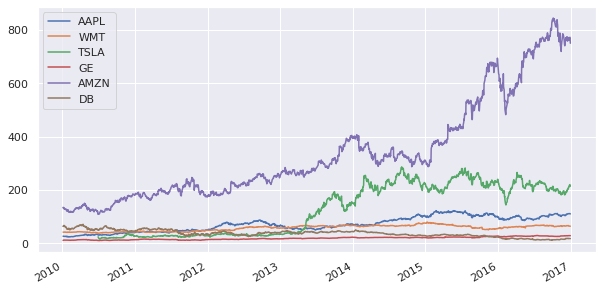

In [106]:
data.plot(kind='line', figsize=(10,5))

Calculate log returns to normalise the data

$$ln(Price_n/Price_{n-1})$$

In [114]:
log_returns = np.log(data/data.shift(1))

In [115]:
log_returns.head()

,AAPL,WMT,TSLA,GE,AMZN,DB
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,0.001729,-0.010007,NaN,0.005157,0.005883,0.018938
2010-01-06,-0.016035,-0.002238,NaN,-0.005157,-0.018282,-0.017436
2010-01-07,-0.001853,0.000560,NaN,0.050484,-0.017160,0.011253
2010-01-08,0.006629,-0.005050,NaN,0.021306,0.026717,0.035496


<AxesSubplot:>

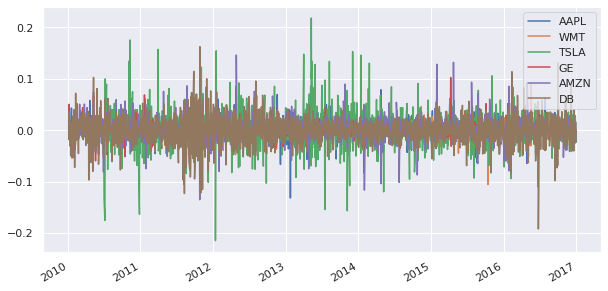

In [116]:
log_returns.plot(kind='line', figsize=(10,5))

Calculate the mean and covariance

In [118]:
log_returns.mean()*252

AAPL    0.203962
WMT     0.060364
TSLA    0.336881
GE      0.134745
AMZN    0.246535
DB     -0.184914
dtype: float64

In [120]:
log_returns.cov()*252

,AAPL,WMT,TSLA,GE,AMZN,DB
AAPL,0.068790,0.009882,0.029643,0.021831,0.027802,0.036292
WMT,0.009882,0.026676,0.010925,0.012961,0.010755,0.020200
TSLA,0.029643,0.010925,0.274997,0.027301,0.047332,0.052298
GE,0.021831,0.012961,0.027301,0.047189,0.025794,0.054411
AMZN,0.027802,0.010755,0.047332,0.025794,0.104093,0.045000
DB,0.036292,0.020200,0.052298,0.054411,0.045000,0.175563


### Markowitz Model Implementation Example

Deals with unsystematic risk through diversification
$$\mu_{portfolio} = \sum_{i} w_i\mu_i$$
$$\sigma_{portfolio}^2 = \sum_{i}\sum_{j}w_iw_j\sigma_{ij}=\underline{W^T}covmatrix\underline{W}$$

In [247]:
# randomly generate weights for the stocks in the portfolio
def init_weights():
    w = np.random.random(len(stocks))
    w /= np.sum(w)
    return w

# calculate the expected portfolio return
def calc_pfolio_return(returns, weights):
    return np.sum(returns.mean()*weights)*252

def calc_pfolio_std(returns, weights):
    return np.sqrt(np.dot(weights.T,np.dot(returns.cov()*252, weights)))

For a given weight, what is the expected return and std?

In [248]:
w = init_weights()
w

array([0.31056114, 0.12163422, 0.05766351, 0.25690845, 0.03507112,
       0.21816157])

In [249]:
calc_pfolio_return(log_returns, w)

0.09303286914341519

In [250]:
calc_pfolio_std(log_returns, w)

0.2050686718021135

### Monte-Carlo Simulations

Monte Carlo simulation is a technique used to understand the impact of risk and uncertainty in financial, project management, cost, and other forecasting models. A Monte Carlo simulator helps one visualize most or all of the potential outcomes to have a better idea regarding the risk of a decision

In [211]:
def gen_pfolios(returns):
    
    preturns = []
    pstd = []
    
    for i in range(10000):
        w = init_weights()
        preturns.append(calc_pfolio_return(log_returns, w))
        pstd.append(calc_pfolio_std(log_returns, w))
    return np.array(preturns), np.array(pstd)

In [212]:
r, s = gen_pfolios(log_returns)

Plot all potential portfolios with expected return and volatility

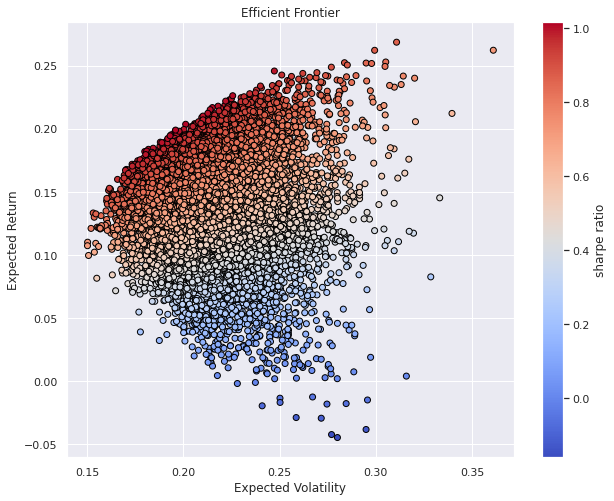

In [220]:
plt.figure(figsize=(10,8))
plt.title('Efficient Frontier')
plt.scatter(s,r, c=r/s, marker='o', cmap='coolwarm', edgecolors='black')
plt.xlabel("Expected Volatility")
plt.ylabel("Expected Return")
plt.colorbar(label='sharpe ratio')

Perform optimisation to identify the best portfolio

In [256]:
def opt_pfolio(weights, returns):
    
    # function to optimise
    def min_sharpe(weights,returns):
        return -calc_pfolio_return(returns,weights)/ calc_pfolio_std(returns,weights)
    
    # sum of the weights is 1
    constraints = (
        {
            'type':'eq', 
            'fun': lambda x: np.sum(x) - 1
        }
    )
    
    # Each weight can only be 1 at most and 0 at least
    bounds = tuple((0,1) for x in range(len(stocks)))
    
    optimum = opt.minimize(
        fun=min_sharpe,
        x0=weights,
        args=returns,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
    )
    return optimum

In [257]:
init_weights()

array([0.0257848 , 0.17280293, 0.20006409, 0.1838996 , 0.13233649,
       0.28511209])

In [259]:
best = opt_pfolio(init_weights(),log_returns)

Most optimal weights

In [265]:
b_weights = best['x'].round(3)
b_weights

array([0.363, 0.077, 0.141, 0.153, 0.265, 0.   ])

Expected Return of best portfolio

In [266]:
b_r = calc_pfolio_return(log_returns, b_weights)
b_r

0.2121340877375571

Expected volatility of best portfolio

In [267]:
b_s = calc_pfolio_std(log_returns, b_weights)
b_s

0.20555557618460626

Expected Sharp Ratio, assuming 0 risk free return

In [269]:
b_r/b_s

1.0320035665052587

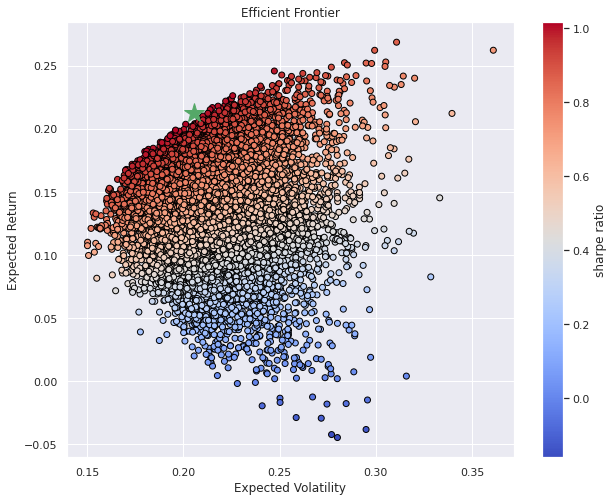

In [268]:
plt.figure(figsize=(10,8))
plt.title('Efficient Frontier')
plt.scatter(s,r, c=r/s, marker='o', cmap='coolwarm', edgecolors='black')
plt.xlabel("Expected Volatility")
plt.ylabel("Expected Return")
plt.colorbar(label='sharpe ratio')
plt.plot(b_s, b_r, 'g*', markersize=20.0)